**Neural network experiment**

# **import user-specified packages and google drive files**

In [1]:
%xmode Verbose

Exception reporting mode: Verbose


In [2]:
from google.colab import files
uploaded = files.upload()

Saving dataset_confs.py to dataset_confs.py
Saving DatasetManager.py to DatasetManager.py


In [3]:
import dataset_confs
from DatasetManager import DatasetManager

# **import datasets**

In [4]:
from google.colab import files
uploaded = files.upload()

Saving Production.csv to Production.csv


In [5]:
csv_files = {
   # "bpic2011": ["BPIC11_f%s"%formula for formula in range(1,2)],
    #"bpic2015": ["BPIC15_%s_f2"%(municipality) for municipality in range(3,6)],
    #"sepsis_cases": ["sepsis_cases_1", "sepsis_cases_2", "sepsis_cases_4"],
    #"bpic2012": ["bpic2012_O_ACCEPTED#COMPLETE","bpic2012_O_CANCELLED-COMPLETE","bpic2012_0_DECLINED-COMPLETE"],
    "production": ["Production"],
    #"bpic2017": ["BPIC17_O_Accepted","BPIC17_O_Cancelled","BPIC17_0_Refused"],
    #"traffic_fines": ["traffic_fines_%s"%formula for formula in range(1,3)],
    #"hospital_billing": ["hospital_billing_%s"%suffix for suffix in [2,3]]
}
files = []
for k, v in csv_files.items():
    files.extend(v)
dataset_ref_to_datasets = {
   # "bpic2011": ["bpic2011_f%s"%formula for formula in range(1,2)],
   # "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(3,6)],
   #"sepsis_cases": ["sepsis_cases_1", "sepsis_cases_2", "sepsis_cases_4"],
    #"bpic2012": ["bpic2012_accepted","bpic2012_cancelled","bpic2012_declined"],
    "production": ["production"],
    #"bpic2017": ["bpic2017_accepted","bpic2017_cancelled","bpic2017_refused"],
    #"traffic_fines": ["traffic_fines_%s"%formula for formula in range(1,3)],
    #"hospital_billing": ["hospital_billing_%s"%suffix for suffix in [2,3]]
}

files = []
for k, v in csv_files.items():
    files.extend(v)
datasets = []
for k, v in dataset_ref_to_datasets.items():
    datasets.extend(v)
res = {datasets[i]: files[i] for i in range(len(datasets))}

In [6]:
datasets

['production']

In [7]:
res

{'production': 'Production'}

# **import packages and functions**

In [8]:
# functions and packages
import pandas as pd
import numpy as np
import os
import pickle
import random
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
from pandas.api.types import is_string_dtype
from collections import OrderedDict
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

#LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, Input, Multiply, concatenate, Embedding, LSTM
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam, Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow.keras.utils as ku
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Softmax, Lambda
from tensorflow.keras import backend

#CNN
from tensorflow.keras.layers import Conv1D

# **Pickle files**

In [9]:
from google.colab import files
uploaded = files.upload()

Saving optimal_params_LSTM_production_all_embeddings.pickle to optimal_params_LSTM_production_all_embeddings.pickle


# **Own created functions**

In [10]:
#functions
#https://towardsdatascience.com/using-neural-networks-with-embedding-layers-to-encode-high-cardinality-categorical-variables-c1b872033ba2
class ColumnEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns = None
        self.maps = dict()

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            # encode value x of col via dict entry self.maps[col][x]+1 if present, otherwise 0
            X_copy.loc[:,col] = X_copy.loc[:,col].apply(lambda x: self.maps[col].get(x, -1)+1)
        return X_copy

    def inverse_transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            values = list(self.maps[col].keys())
            # find value in ordered list and map out of range values to None
            X_copy.loc[:,col] = [values[i-1] if 0<i<=len(values) else None for i in X_copy[col]]
        return X_copy

    def fit(self, X, y=None):
        # only apply to string type columns
        self.columns = [col for col in X.columns if is_string_dtype(X[col])]
        for col in self.columns:
            self.maps[col] = OrderedDict({value: num for num, value in enumerate(sorted(set(X[col])))})
        return self

def prepare_inputs(X_train, X_test, data):  
    global ce
    ce = ColumnEncoder()
    X_train, X_test = X_train.astype(str), X_test.astype(str)
    X_train_enc = ce.fit_transform(X_train)
    X_test_enc = ce.transform(X_test)
    return X_train_enc, X_test_enc
    
def numeric_padding(sequences, maxlen=None, value=0):
    num_samples = len(sequences)
    sample_shape = np.asarray(sequences[0]).shape[1:]
    x = np.full((num_samples, maxlen) + sample_shape, value)
    for idx, s in enumerate(sequences):
        trunc = s[:maxlen]
        x[idx, :maxlen] = trunc[0]
        
def create_index(log_df, column):
    """Creates an idx for a categorical attribute.
    Args:
        log_df: dataframe.
        column: column name.
    Returns:
        index of a categorical attribute pairs.
    """
    temp_list = log_df[[column]].values.tolist()
    subsec_set = {str((x[0])) for x in temp_list}
    subsec_set = sorted(list(subsec_set))
    alias = dict()
    for i, _ in enumerate(subsec_set):
        alias[subsec_set[i]] = i + 1
    return alias

def groupby_caseID(data, cols):
    ans = [pd.DataFrame(y) for x, y in data[cols].groupby('Case ID', as_index=False)]
    return ans

def remove_punctuations(columns_before):
    columns = []
    for string in columns_before:
        new_string = string.replace(":", "_")
        columns.append(new_string)
    return columns

#call this function with the name of the right column
def create_indexes(i, data):
    cat_index = create_index(data, i)
    cat_index['Start'] = 0
    cat_index['End'] = len(cat_index)
    index_cat = {v: k for k, v in cat_index.items()}
    cat_weights = ku.to_categorical(sorted(index_cat.keys()), len(cat_index))
    no_cols = len(data.groupby([i]))+1
    return cat_weights, index_cat, cat_index, no_cols

def labels_after_grouping(data_train,data_test):
    train_labels = []
    for i in range (0,len(data_train)):
        temp_label = data_train[i]['label'].iloc[0]
        train_labels.append(temp_label)

    test_labels = []
    for i in range (0,len(data_test)):
        temp_label = data_test[i]['label'].iloc[0]
        test_labels.append(temp_label)
    train_y = [1 if i!='regular' else 0 for i in train_labels]
    test_y = [1 if i!='regular' else 0 for i in test_labels]
    return train_y, test_y

def pad_cat_data(cols, data_train, data_test, maxlen):
    
    #padding of the different categorical columns
    #train paddings
    paddings_train = []
    for i in cols:
        padding= []
        for k in range(0,len(data_train)):
            temp = []
            temp = list(data_train[k][i])
            padding.append(temp)
        padded = np.array(pad_sequences(padding,maxlen=maxlen, padding='pre', truncating='pre',value=0))
        #padded = padded/len(data.groupby([i]))
        paddings_train.append(padded)

    #test paddings
    paddings_test = []
    for i in cols:
        padding= []
        for k in range(0,len(data_test)):
            temp = []
            temp = list(data_test[k][i])
            padding.append(temp)
        padded = np.array(pad_sequences(padding,maxlen=maxlen, padding='pre', truncating='pre',value=0))
        #padded = padded/len(data.groupby([i]))
        paddings_test.append(padded)
    return paddings_train, paddings_test

def pad_num_data(cols, data_train, data_test, maxlen, dt_train_prefixes, dt_test_prefixes):
    pad_train = []
    pad_test  = []
    for i in cols:
        
        padding = []
        for k in range(0,len(data_train)):
            temp_train = []
            temp_train = list(data_train[k][i])
            padding.append(temp_train)

        padded = np.array(pad_sequences(padding,maxlen=maxlen, padding='pre', truncating='pre',value=0))
        if dt_train_prefixes[i].max() !=0:
           
            padded = padded/dt_train_prefixes[i].max()
        else:
            padded = padded
        pad_train.append(padded)
   
    for i in cols:
      
        padding = []
        for k in range(0,len(data_test)):
            temp_test = []
            temp_test = list(data_test[k][i])
            padding.append(temp_test)
      
        padded = np.array(pad_sequences(padding,maxlen=maxlen, padding='pre', truncating='pre',value=0))
        if dt_test_prefixes[i].max() !=0:
            padded = padded/dt_test_prefixes[i].max()
        else:
            padded = padded
        pad_test.append(padded)
    return pad_train, pad_test

def reshape_num_data(pad_data, cutoff):
        pad_num = np.reshape(pad_data, (len(pad_data), cutoff, 1))
        return pad_num

# **Attention**

In [22]:
def attention():
    #  Generation of predictions
    layer_names = [layer.name for layer in model.layers]
    print(layer_names)
    ac_output_weights, ac_bias = model.get_layer(name='final_output').get_weights()
    model_with_attention = Model(model.inputs, model.outputs +\
                                                  [model.get_layer(name='alpha_softmax').output,\
                                                   model.get_layer(name='beta_dense_0').output])
    temporal_vectors = []
    variable_vectors=[]
    predictions = []
    for i in range(len(paddings_train[0])):
        x_ngram_list = []
        for j in range(0,len(paddings_train)):
                x_ngram = paddings_train[j][i].reshape((1,cutoff))
                x_ngram_list.append(x_ngram)

        for k in range(0,len(pad_train)):
                x_ngram = np.reshape(pad_train[k], (len(pad_train[k]), cutoff, 1))[i].reshape(1,cutoff,1)
                x_ngram_list.append(x_ngram)

        #extend list and add time 
        x_ngram_list.append(padded_time[i].reshape(1,cutoff,1))

        proba, alphas, betas = model_with_attention.predict(x_ngram_list)
        proba = np.squeeze(proba)
        alphas = np.squeeze(alphas)
        temporal_att_vec = alphas
        assert (np.sum(temporal_att_vec) - 1.0) < 1e-5

        #print(temporal_att_vec)
        temporal_vectors.append(temporal_att_vec)

        #get the beta value
        betas = np.squeeze(betas)
        idx = np.argmax(alphas)

        #print(idx)
        beta_val = betas[idx]

        dim = 0
        emb_list = []
        for i in range(0,len(paddings_train)):
            ip = int(x_ngram_list[i][0][idx])
            i = cat_cols[i]
            i = i.replace(':','_')
            i = i.replace(' ','_')
            emb_weights = model.get_layer(name='embed_'+i).get_weights()[0]
            emb = emb_weights[ip]
            emb_list.append(emb)
            dim += emb.shape[0]


        for i in range(0,len(pad_train)):
            x_ngram = (reshape_num_data(pad_train[k], cutoff))[i].reshape(1,cutoff,1)
            num = np.squeeze(x_ngram)[idx]
            emb_list.append(num)
            dim +=1
        #if cls_method =='LSTM':
        if(betas.shape[1]==dim+1):
            x_t_ngram = padded_time[i].reshape(1, cutoff, 1)
            time_v = np.squeeze(x_t_ngram)[idx]
            emb_list.append(time_v)
            emb = np.concatenate(tuple(emb_list), axis=None)
            #print('beta_val',beta_val.shape)
            beta_scaled = np.multiply(beta_val,emb)
            variable_attn = alphas[idx] * beta_scaled
            variable_vectors.append(variable_attn)
            predictions.append(proba)
       
    if(len(variable_vectors)>0):
        var_final = np.mean(np.array(variable_vectors), axis=0)
        cat_labels_list = []
        current_length = 0
        for i in dt_train_prefixes[cat_cols].columns:
            cat_weights, index_cat, cat_index, no_cols = create_indexes(i, data)
            cat_labels = [index_cat[key] for key in sorted(index_cat.keys())]
            cat_labels_list.extend(cat_labels)

        for i in dt_train_prefixes[numerical_columns].columns:
            cat_labels_list.append(i)
        cat_labels_list.append('time')
        
        df_var=pd.DataFrame({'attributes':var_final, 'attribute_values':cat_labels_list})
        print(df_var)
        df_var.plot.bar(y='attributes', x='attribute_values',
                                    title='Attention of the event attributes.', figsize=(10,7))

        #plot_history( plt, file_name + 'variable_attn', path )

        # Hide grid lines
        plt.grid(False)
        plt.show()
        attention_values = []
        for i in dt_train_prefixes[cat_cols].columns:
            cat_weights, index_cat, cat_index, no_cols = create_indexes(i, data)
            new_length = len([index_cat[key] for key in sorted(index_cat.keys())])
            attention_value = abs(df_var['attributes'].iloc[current_length:current_length+new_length]).sum(skipna = True)
            attention_values.append(attention_value)
            current_length += new_length
      
        for i in dt_train_prefixes[numerical_columns].columns:
            attention_values.append(abs(df_var['attributes'].iloc[current_length:current_length+1]).sum(skipna = True))
            current_length+1

        attention_values.append(abs(df_var['attributes'].iloc[current_length:current_length+1]).sum(skipna = True))

    return df_var, attention_values

# **Parsimony**

In [12]:
def var_importance(model, model_inputs, sample_length):
    effects_saved = []
    x = data_sample(model_inputs, sample_length)
    orig_out = model.predict(x)
    for i in range(0,len(cat_cols)):  # iterate over the 5 cat features
        print(" ")
        new_x = x.copy()
        perturbations_list = []
        for j in range(0,sample_length):
            prefix_array = np.random.random((maxlen,))
            perturbations_list.append(prefix_array)
        new_x[i] = np.array(perturbations_list)
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5
        print(f'Variable {i+1}, perturbation effect: {effect:.4f}')
        effects_saved.append(effect)
    for k in range(i+1,len(model_inputs)):  # iterate over the 2 num features
        print(k)
        new_x = x.copy()
        perturbations_list = []
        for j in range(0,sample_length):
            prefix_array = np.random.random((maxlen,))
            perturbations_list.append(prefix_array)
        perturbation_array = np.array(perturbations_list)
        perturbations_reshaped = perturbation_array.reshape(sample_length, cutoff, 1)
        new_x[k] = perturbations_reshaped
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5
        print(f'Variable {(k+1)}, perturbation effect: {effect:.4f}')    
        effects_saved.append(effect)
    return effects_saved 

In [13]:
def parsimony(attention_values):
  #feature importance of original model
  feature_importance=pd.DataFrame()
  columns = cat_cols+numerical_columns
  columns.append('time')
  feature_importance['variable']=columns
  feature_importance['coefficients'] = attention_values
  
  count_event = 0
  count_case = 0
  count_control = 0

  # event columns
  model_event = feature_importance[feature_importance['variable'].isin(event_columns)]
  model_event = model_event['coefficients'].tolist()
  #case columns
  model_case= feature_importance[feature_importance['variable'].isin(case_columns)]
  model_case = model_case['coefficients'].tolist()
  count_case += model_case.count(0.0)
  #controlflow columns
  model_control= feature_importance[feature_importance['variable'].isin(controlflow_columns)]
  model_control = model_control['coefficients'].tolist()
  count_control += model_control.count(0.0)
  parsimony_event = (len_event-count_event)/len_event
  parsimony_case = (len_case-count_case)/len_case 
  parsimony_control = (len_control-count_control)/len_control
  print('event attributes and percentage of event attributes:',len_event-count_event, parsimony_event)
  print('case attributes and percentage of case attributes:', len_case-count_case, parsimony_case)
  print('controlflow attributes and percentage of controlflow attributes', len_control-count_control, parsimony_control)

  return parsimony_event, parsimony_case, parsimony_control


# **Functional complexity**

In [14]:
def create_test_data(dt_test_prefixes):

  #cat columns integerencoded
  cat_cols = cls_encoder_args['dynamic_cat_cols']+cls_encoder_args['static_cat_cols']
  dt_test_prefixes[cat_cols] = dt_test_prefixes[cat_cols].astype(str)
  dt_test_prefixes[cat_cols] = ce.transform(dt_test_prefixes[cat_cols])
  dt_test_prefixes[cat_cols] = dt_test_prefixes[cat_cols]+1
  
  #append caseId and label
  cat_cols.append('Case ID')
  cat_cols.append('label')
  #groupby case ID
  ans_test = groupby_caseID(dt_test_prefixes, cat_cols)

  #remove then back
  cat_cols.remove('label')
  cat_cols.remove('Case ID')
  
  #pad cat columns
  paddings_test = []
  for i in cat_cols:
        padding= []
        for k in range(0,len(ans_test)):
            temp = []
            temp = list(ans_test[k][i])
            padding.append(temp)
        padded = np.array(pad_sequences(padding,maxlen=maxlen, padding='pre', truncating='pre',value=0))
        paddings_test.append(padded)
  
  #NUMERICAL COLUMNS
  numerical_columns = cls_encoder_args['dynamic_num_cols']+cls_encoder_args['static_num_cols']
  numerical_columns.remove('timesincelastevent')
 
  numerical_columns.append('Case ID')
  ans_test2 = groupby_caseID(dt_test_prefixes, numerical_columns )
  numerical_columns.remove('Case ID')
  pad_test  = []
  
  for i in numerical_columns:
        padding = []
        for k in range(0,len(ans_test2)):
            temp_test = []
            temp_test = list(ans_test2[k][i])
            padding.append(temp_test)
        padded = np.array(pad_sequences(padding,maxlen=maxlen, padding='pre', truncating='pre',value=0))
        if dt_test_prefixes[i].max() !=0:
            padded = padded/dt_test_prefixes[i].max()
        else:
            padded = padded
        pad_test.append(padded)
  
  #TIME COLUMN
  ans_time_test = groupby_caseID(dt_test_prefixes,['timesincelastevent', 'Case ID'])
  cols = ['timesincelastevent'] 
  pad_time_test = []
  for i in cols:
        padding = []
        for k in range(0,len(ans_time_test)):
            temp_test = []
            temp_test = list(ans_time_test[k][i])
            padding.append(temp_test)

        padded = np.array(pad_sequences(padding,maxlen=maxlen, padding='pre', truncating='pre',value=0))
        if dt_test_prefixes[i].max() !=0:
            padded = padded/dt_test_prefixes[i].max()
        else:
            padded = padded
        pad_time_test.append(padded)
  
  padded_time_test=  reshape_num_data(pad_time_test[0], cutoff)
            
  return pad_test, paddings_test, padded_time_test

In [15]:
def distance(lista, listb):
    runsum = 0.0
    for a, b in zip(lista, listb):
        # square the distance of each
        #  then add them back into the sum
        runsum += abs(b - a)   

    # square root it
    return runsum 

def functional_complexity(test_data, n_instances):
    NF_event=0
    NF_case=0
    NF_control=0
    new_model_inputs_test = []
    
    
    #the original prediction, flattened
    pred1 = model.predict(model_inputs_test)
    
    lst3 = []
    lst3.extend(pred1)
    flat_pred1 = [round(item) for sublist in lst3 for item in sublist]
      
    ###EVENT COLUMNS###
    print('event columns')
    result2 = test_data.copy()

    for j in event_columns:
        new_items = []
        permuted_values  = set(result2[j].values)
        for i in range(0,n_instances):
            value = result2[j].iloc[i]
            permuted_list = np.setdiff1d(list(permuted_values),[value])
            if len(permuted_list)<1:
                random_value = value
            else:
                random_value = random.choice(permuted_list)
            new_items.append(random_value)
        
        result2[j] = new_items
 
    new_pad_test, new_paddings_test, new_padded_time_test = create_test_data(result2)
        
     #add the permuted padded data to the new_model_inputs list
    for i in range(0,len(new_paddings_test)):
        new_model_inputs_test.append(new_paddings_test[i])

    for i in range(0,len(pad_test)):
        new_model_inputs_test.append(reshape_num_data(new_pad_test[i], cutoff))
    
    #add padded time
    new_model_inputs_test.append(new_padded_time_test)

   
    pred2 = model.predict(new_model_inputs_test)
    lst3 = []
    lst3.extend(pred2)
    flat_pred2 = [round(item) for sublist in lst3 for item in sublist]
  
    
    NF_event = distance(flat_pred1, flat_pred2)
    print(NF_event, n_instances)
    FC_event = NF_event/(n_instances)
    print('FC_event: ', FC_event)

    ###CASE COLUMNS###
    print('case columns')
    result2 = test_data.copy()
    new_model_inputs_test = []
    for j in case_columns:
        new_items = []
        permuted_values  = set(result2[j].values)
        for i in range(0,n_instances):
            value = result2[j].iloc[i]
            permuted_list = np.setdiff1d(list(permuted_values),[value])
            if len(permuted_list)<1:
                random_value = value
            else:
                random_value = random.choice(permuted_list)
            new_items.append(random_value)
        
        result2[j] = new_items

    new_pad_test, new_paddings_test, new_padded_time_test = create_test_data(result2)
        
     #add the permuted padded data to the new_model_inputs list
    for i in range(0,len(new_paddings_test)):
        new_model_inputs_test.append(new_paddings_test[i])

    for i in range(0,len(pad_test)):
        new_model_inputs_test.append(reshape_num_data(new_pad_test[i], cutoff))
    
    #add padded time
    new_model_inputs_test.append(new_padded_time_test)

    pred2 = model.predict(new_model_inputs_test) 
   
    lst3 = []
    lst3.extend(pred2)
    flat_pred3 = [round(item) for sublist in lst3 for item in sublist]
  
    
    NF_case = distance(flat_pred1, flat_pred3)
    print(NF_case, n_instances)
    FC_case = NF_case/(n_instances)
    print('FC_case: ', FC_case)
    
    
    #CONTROLFLOW COLUMNS###
    print('control columns')
    result2 = test_data.copy()
    new_model_inputs_test = []

    for j in controlflow_columns:
        new_items = []
        permuted_values  = set(result2[j].values)
        for i in range(0,n_instances):
            value = result2[j].iloc[i]
            permuted_list = np.setdiff1d(list(permuted_values),[value])
            if len(permuted_list)<1:
                random_value = value
            else:
                random_value = random.choice(permuted_list)
            new_items.append(random_value)
        
        result2[j] = new_items

    new_pad_test, new_paddings_test, new_padded_time_test = create_test_data(result2)
        
     #add the permuted padded data to the new_model_inputs list
    for i in range(0,len(new_paddings_test)):
        new_model_inputs_test.append(new_paddings_test[i])

    for i in range(0,len(pad_test)):
        new_model_inputs_test.append(reshape_num_data(new_pad_test[i], cutoff))
    
    #add padded time
    new_model_inputs_test.append(new_padded_time_test)

    pred2 = model.predict(new_model_inputs_test)
  
    lst3 = []
    lst3.extend(pred2)
    flat_pred4 = [round(item) for sublist in lst3 for item in sublist]
  
    
    NF_control = distance(flat_pred1, flat_pred4)
    print(NF_control, n_instances)
    FC_control = NF_control/(n_instances)
    print('FC_control: ', FC_control)
    
    return FC_event, FC_case, FC_control

# **Monotonicity**

In [16]:
def numbers_list():
    numbers = []
    for i in cat_cols:
        no_cols = len(data.groupby([i]))+1
        numbers.append(no_cols)

    for i in numerical_columns:
        numbers.append(1)

    #time layer
    numbers.append(1)
    return numbers

def data_sample(model_inputs, sample_length):
    sample_data = []
    for i in range(0, len(model_inputs)):
        sample_data.append(model_inputs[i][0:sample_length])
    return sample_data


def monotonicity(attention_values, effects_saved):
    len(attention_values)
    # prepare data
    coef, p = spearmanr(attention_values, effects_saved)
    print('lengths', len(attention_values), len(effects_saved))
    print('Spearmans correlation coefficient: %.3f' % coef)
    # interpret the significance
    alpha = 0.05
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    else:
        print('Samples are correlated (reject H0) p=%.3f' % p)

    #feature importance of original model
    feature_importance=pd.DataFrame()
    columns = cat_cols + numerical_columns
    columns.append('time')
    feature_importance['columns']=columns
    feature_importance['importances'] = effects_saved
    attention_importances=pd.DataFrame()
    attention_importances['columns']=columns
    attention_importances['importances_attention'] = attention_values

    #resulting frame
    resulting_frame = pd.concat([attention_importances, feature_importance], join='inner', axis=1)
    resulting_frame.sort_values(by='importances',ascending=False,inplace=True)

     #top 10 of attention values importances and extract which columns are in it
    attention_importances.sort_values(by='importances_attention',ascending=False,inplace=True)
    attention_top_10 = attention_importances[:10]
    #attention_event
    attention_event = len(attention_top_10[attention_top_10['columns'].isin(event_columns)])
    #attention_case
    attention_case = len(attention_top_10[attention_top_10['columns'].isin(case_columns)])
    #attention_control
    attention_control = len(attention_top_10[attention_top_10['columns'].isin(controlflow_columns)])
    
    #similar for original model
    feature_importance.sort_values(by='importances',ascending=False,inplace=True)
    feature_top_10 = feature_importance[:10]
    #feature-event
    feature_event = len(feature_top_10[feature_top_10['columns'].isin(event_columns)])
    #feature-case
    feature_case = len(feature_top_10[feature_top_10['columns'].isin(case_columns)])
    #feature_control
    feature_control = len(feature_top_10[feature_top_10['columns'].isin(controlflow_columns)])


    return (coef, attention_event, attention_case, attention_control, feature_event, feature_case, feature_control)

# **parameters**

In [17]:
# parameters
#terminology 
results_dir = './results_DL' 
column_selection= 'all'
cls_encoding ='embeddings'
classifiers =['LSTM','CNN']
n_iter = 1
n_splits = 3
train_ratio = 0.8
random_state = 22
l2reg = 0.001

allow_negative=False
incl_time = True 
incl_res = True
# create results directory
if not os.path.exists(os.path.join(results_dir)):
    os.makedirs(os.path.join(results_dir))

# **Function for preprocessing the data**

In [18]:
def create_data(dt_train_prefixes, dt_test_prefixes):


  #get the label of the train and test set
  test_y = dataset_manager.get_label_numeric(dt_test_prefixes)
  train_y = dataset_manager.get_label_numeric(dt_train_prefixes)   
  
  #cat columns integerencoded
  cat_cols = cls_encoder_args['dynamic_cat_cols']+cls_encoder_args['static_cat_cols']

  dt_train_prefixes[cat_cols],dt_test_prefixes[cat_cols]= prepare_inputs(dt_train_prefixes[cat_cols], dt_test_prefixes[cat_cols], data)
  dt_train_prefixes[cat_cols] = dt_train_prefixes[cat_cols]+1
  dt_test_prefixes[cat_cols] = dt_test_prefixes[cat_cols]+1
  #append caseId and label
  cat_cols.append('Case ID')
  cat_cols.append('label')
  #groupby case ID
  
  ans_train = groupby_caseID(dt_train_prefixes, cat_cols)
  ans_test = groupby_caseID(dt_test_prefixes, cat_cols)
  #obtain the new label lists after grouping
  train_y, test_y = labels_after_grouping(ans_train, ans_test)
  #remove then back
  cat_cols.remove('label')
  cat_cols.remove('Case ID')
  #pad cat columns
  paddings_train, paddings_test = pad_cat_data(cat_cols, ans_train, ans_test, maxlen)
  
  #NUMERICAL COLUMNS
  numerical_columns = cls_encoder_args['dynamic_num_cols']+cls_encoder_args['static_num_cols']
  numerical_columns.remove('timesincelastevent')
 
  numerical_columns.append('Case ID')
  ans_train2 = groupby_caseID(dt_train_prefixes, numerical_columns)
  ans_test2 = groupby_caseID(dt_test_prefixes, numerical_columns )
  numerical_columns.remove('Case ID')  
  pad_train, pad_test = pad_num_data(numerical_columns, ans_train2, ans_test2, maxlen, dt_train_prefixes, dt_test_prefixes)
  
  #time inputs                   
  ans_time_train= groupby_caseID(dt_train_prefixes,['timesincelastevent', 'Case ID'])
  ans_time_test = groupby_caseID(dt_test_prefixes,['timesincelastevent', 'Case ID'])
  pad_time_train, pad_time_test = pad_num_data(['timesincelastevent'], ans_time_train, ans_time_test, maxlen, dt_train_prefixes, dt_test_prefixes)
  #reshape the time input
  padded_time = reshape_num_data(pad_time_train[0], cutoff)
  padded_time_test=  reshape_num_data(pad_time_test[0], cutoff)
            
  return pad_train, pad_test, paddings_train, paddings_test, padded_time, padded_time_test, train_y, test_y

# **loop over datasets and classifiers**

Dataset: production
Classifier LSTM
Encoding embeddings
{'batch_size': 160, 'dropout_rate': 0.25236146584363134, 'learning_rate': 0.0020729857246068453, 'lstm_size': 80, 'optimizer': 'Nadam'}
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Activity (InputLayer)          [(None, 23)]         0           []                               
                                                                                                  
 Resource (InputLayer)          [(None, 23)]         0           []                               
                                                                                                  
 Report_Type (InputLayer)       [(None, 23)]         0           []                               
                                                                                                  

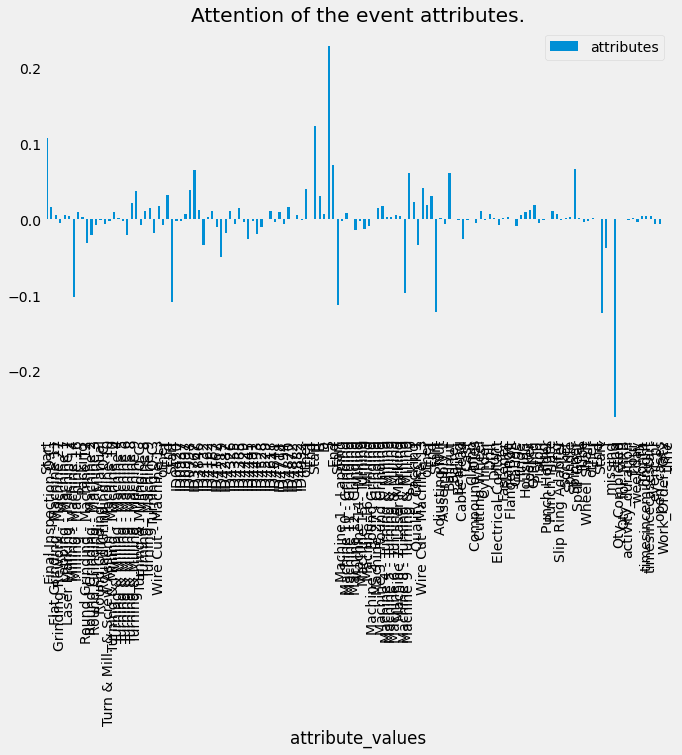

 
Variable 1, perturbation effect: 0.1428
 
Variable 2, perturbation effect: 0.6040
 
Variable 3, perturbation effect: 0.0781
 
Variable 4, perturbation effect: 0.0470
 
Variable 5, perturbation effect: 0.4630
 
Variable 6, perturbation effect: 0.0493
6
Variable 7, perturbation effect: 0.0124
7
Variable 8, perturbation effect: 0.0393
8
Variable 9, perturbation effect: 0.0295
9
Variable 10, perturbation effect: 0.0115
10
Variable 11, perturbation effect: 0.0372
11
Variable 12, perturbation effect: 0.0159
12
Variable 13, perturbation effect: 0.0166
13
Variable 14, perturbation effect: 0.0281
14
Variable 15, perturbation effect: 0.0218
15
Variable 16, perturbation effect: 0.0135
16
Variable 17, perturbation effect: 0.4608
17
Variable 18, perturbation effect: 0.3023
event attributes and percentage of event attributes: 14 1.0
case attributes and percentage of case attributes: 3 1.0
controlflow attributes and percentage of controlflow attributes 1 1.0
event columns
171.0 1472
FC_event:  0.11

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dataset: production
Classifier CNN
Encoding embeddings
problem


FileNotFoundError: ignored

In [23]:
for cls_method in classifiers:
    for dataset_name in datasets:
            dataset_name_csv = res[dataset_name]
            print('Dataset:', dataset_name)
            print('Classifier', cls_method)
            print('Encoding', cls_encoding)
            method_name = "%s_%s"%(column_selection, cls_encoding)            

            optimal_params_filename = os.path.join("", "optimal_params_%s_%s_%s.pickle" % (cls_method, dataset_name, method_name))
            if not os.path.isfile(optimal_params_filename) or os.path.getsize(optimal_params_filename) <= 0:
                print('problem')
            with open(optimal_params_filename, "rb") as fin:
                args = pickle.load(fin)
                print(args)
                
            # read the data
            dataset_manager = DatasetManager(dataset_name)
            data = pd.read_csv(dataset_name_csv+'.csv', sep=';')
            if dataset_name in ['bpic2011_f1', 'bpic2011_f2', 'bpic2011_f3', 'bpic2011_f4','bpic2015_1_f2','bpic2015_2_f2','bpic2015_3_f2','bpic2015_4_f2','bpic2015_5_f2','sepsis_cases_1','sepsis_cases_2','sepsis_cases_4']:
              data['time:timestamp'] = pd.to_datetime(data['time:timestamp'])
            if dataset_name in ['bpic2012_accepted', 'bpic2012_cancelled', 'bpic2012_declined']:
              data['Complete Timestamp'] = pd.to_datetime(data['Complete Timestamp'])
            data['timesincemidnight'] = data['timesincemidnight']/60
            data['timesincemidnight'] = round(data['timesincemidnight'],0)
            data['timesincecasestart'] = data['timesincecasestart']/60
            data['timesincecasestart'] = round(data['timesincecasestart'],0)
            data['timesincelastevent'] = data['timesincelastevent']/60
            data['timesincelastevent'] = round(data['timesincelastevent'],0)
            
            
            cls_encoder_args = {'case_id_col': dataset_manager.case_id_col, 
                        'static_cat_cols': dataset_manager.static_cat_cols,
                        'static_num_cols': dataset_manager.static_num_cols, 
                        'dynamic_cat_cols': dataset_manager.dynamic_cat_cols,
                        'dynamic_num_cols': dataset_manager.dynamic_num_cols, 
                        'fillna': True}
            
            #file to save results
            outfile = os.path.join('', "performance_results_%s_%s_%s.csv" % (cls_method, dataset_name, method_name))
            
            # determine min and max (truncated) prefix lengths
            min_prefix_length = 1
            if "traffic_fines" in dataset_name:
                max_prefix_length = 10
            elif "bpic2017" in dataset_name:
                max_prefix_length = min(20, dataset_manager.get_pos_case_length_quantile(data, 0.90))
            else:
                max_prefix_length = min(40, dataset_manager.get_pos_case_length_quantile(data, 0.90))
            maxlen = cutoff = max_prefix_length
            
            # split into training and test
            train, test = dataset_manager.split_data_strict(data, train_ratio, split="temporal")
            
            #prefix generation of train and test data
            dt_train_prefixes = dataset_manager.generate_prefix_data(train, min_prefix_length, max_prefix_length)
            dt_test_prefixes = dataset_manager.generate_prefix_data(test, min_prefix_length, max_prefix_length)

            pad_train, pad_test, paddings_train, paddings_test, padded_time, padded_time_test, train_y, test_y = create_data(dt_train_prefixes, dt_test_prefixes)
            cat_cols = cls_encoder_args['dynamic_cat_cols']+cls_encoder_args['static_cat_cols']
        
            numerical_columns = cls_encoder_args['dynamic_num_cols']+cls_encoder_args['static_num_cols']
            numerical_columns.remove('timesincelastevent')

            #control flow, event and case 
            event_columns = cls_encoder_args['dynamic_cat_cols']+cls_encoder_args['dynamic_num_cols']
            controlflow_columns =  [x for x in event_columns if 'Activity' in x]
            event_columns.remove(controlflow_columns[0])
            case_columns = cls_encoder_args['static_cat_cols']+cls_encoder_args['static_num_cols']
            len_event = len(event_columns)
            len_case = len(case_columns)
            len_control = len(controlflow_columns)

            #create the input layers and embeddings
            embeddings= []
            input_layers = []
            preds_all = []
            nr_events_all = []
            test_y_all = []
            score = 0
            dim = 0
            test_y_all = []
            test_y_all.extend(test_y)
            nr_events = list(dataset_manager.get_prefix_lengths(dt_test_prefixes))
            nr_events_all.extend(nr_events)
            
            for i in cat_cols:
                cat_weights, index_cat, cat_index, no_cols = create_indexes(i, data)
                i = i.replace(':','_')
                i = i.replace(' ','_')
                input_layer = Input(shape=(cutoff,), name=i)
                embedding = Embedding(cat_weights.shape[0],
                                              cat_weights.shape[1],
                                              weights=[cat_weights],
                                              input_length=no_cols,
                                            name='embed_'+i)(input_layer)
                embeddings.append(embedding)
                input_layers.append(input_layer)
                dim += cat_weights.shape[1]

            #static input layers

            for j in numerical_columns:
                j = j.replace('(','_')
                j = j.replace(')','_')
                j = j.replace(' ','_')
                j = j.replace(':','_')
                input_layer = Input(shape=(cutoff,1), name=j)
                input_layers.append(input_layer)
                embeddings.append(input_layer)
                dim +=1

            #create the model inputs
            model_inputs= []
            model_inputs_test= []
            for i in range(0,len(paddings_train)):
                    model_inputs.append(paddings_train[i])

            for i in range(0,len(paddings_test)):
                    model_inputs_test.append(paddings_test[i])

            for i in range(0,len(pad_train)):
                    model_inputs.append(reshape_num_data(pad_train[i], cutoff))

            for i in range(0,len(pad_test)):
                    model_inputs_test.append(reshape_num_data(pad_test[i], cutoff))

            model_inputs.append(padded_time)
            model_inputs_test.append(padded_time_test)

             #Apply dropout on inputs
            full_embs = concatenate(embeddings, name='full_embedding')
            full_embs = Dropout(args['dropout_rate'])(full_embs)
            time_input_layer = Input(shape=(cutoff,1), name='time_input')
            input_layers.append(time_input_layer)
            time_embs = concatenate([full_embs, time_input_layer], name='allInp')
            dim += 1
            l2reg=0.001

            if cls_method =='LSTM':
                
                #Compute alpha, visit attention
                alpha = Bidirectional(LSTM(args['lstm_size'], return_sequences=True), name='alpha')
                alpha_out = alpha(time_embs)
                alpha_dense = Dense(1, kernel_regularizer=l2(l2reg))
                alpha_out = TimeDistributed(alpha_dense, name='alpha_dense_0')(alpha_out)
                alpha_out = Softmax(axis=1, name='alpha_softmax')(alpha_out)
                
                
                #Compute beta, codes attention
                beta = Bidirectional(LSTM(args['lstm_size'], return_sequences=True),   name='beta')
                beta_out = beta(time_embs)
                beta_dense = Dense(dim, activation='tanh', kernel_regularizer=l2(l2reg))
                beta_out = TimeDistributed(beta_dense, name='beta_dense_0')(beta_out)
                
                #Compute context vector based on attentions and embeddings
                c_t = Multiply()([alpha_out, beta_out, time_embs])
                c_t = Lambda(lambda x: backend.sum(x, axis=1))(c_t)

                #Make a prediction
                contexts = Dropout(args['dropout_rate'])(c_t)
                output_layer = Dense(1, activation='sigmoid', name='final_output')(contexts)

            if cls_method =='CNN':

                #conv layer
                #input shape of conv1D: (sequences, feature dimension)
                #compute alpha
                alpha_dense = Dense(1, kernel_regularizer=l2(l2reg))
                alpha_out = TimeDistributed(alpha_dense, name='alpha_dense_0')(time_embs)
                alpha_out = Softmax(axis=1, name='alpha_softmax')(alpha_out)
                
                conv1_alpha = Conv1D(filters=time_embs.shape[2], kernel_size= int(time_embs.shape[1]), activation='tanh', input_shape=(maxlen,time_embs.shape[0]))(alpha_out)
                #compute beta           
                beta_dense = Dense(dim, activation='tanh', kernel_regularizer=l2(l2reg))
                beta_out = TimeDistributed(beta_dense, name='beta_dense_0')(time_embs) 
                conv1_beta = Conv1D(filters=time_embs.shape[2], kernel_size=int(time_embs.shape[1]), activation='tanh', input_shape=(maxlen,time_embs.shape[0]))(beta_out)
                #alpha_out = Conv1D(filters=args['filters'], kernel_size= int(alpha_out.shape[1]), activation='tanh', input_shape=(maxlen,time_embs.shape[0]))(alpha_out)
                #beta_out = Conv1D(filters=args['filters'], kernel_size=int(beta_out.shape[1]), activation='tanh', input_shape=(maxlen,time_embs.shape[0]))(beta_out)
              
                #Compute context vector based on attentions and embeddings
                c_t = Multiply()([conv1_alpha, conv1_beta, time_embs])
                c_t = Lambda(lambda x: backend.sum(x, axis=1))(c_t)
                print('cont')
                #Make a prediction
                contexts = Dropout(args['dropout_rate'])(c_t)
                dense_layer = Dense(args['filters'], activation='relu', name='dense_output')(contexts)
                output_layer = Dense(1, activation='sigmoid', name='final_output')(dense_layer)
                
             #MODEL
            model = Model(inputs=[input_layers], outputs=output_layer)

            if args['optimizer']=='RMSprop':
                  opt = RMSprop(learning_rate=args['learning_rate'])
            if args['optimizer']=='Nadam':
                  opt = Nadam(learning_rate=args['learning_rate'])
            if args['optimizer']=='Adam':
                  opt = Adam(learning_rate=args['learning_rate'])
            if args['optimizer']=='SGD':
                  opt = SGD(learning_rate=args['learning_rate'])

            model.compile(loss={'final_output':'binary_crossentropy'}, optimizer= opt)

            model.summary()

            early_stopping = EarlyStopping(monitor='val_loss', patience=42)
            model_checkpoint = ModelCheckpoint('output_files/models/model_{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
            lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

            result = model.fit(model_inputs,
                  np.array(train_y),
                  callbacks=[early_stopping, lr_reducer],
                  validation_split = 0.1,
                  verbose=2, batch_size=args['batch_size'],
                  epochs=500)
            pred = model.predict(model_inputs_test)
            preds_all.extend(pred)
            auc_total = roc_auc_score(test_y_all, preds_all)

            #columns
            #controlflow columns
            controlflow_columns = [word for word in cls_encoder_args['dynamic_cat_cols'] if word.startswith('Act')]
            
            len_control = len(controlflow_columns)
            
            #event columns
            event_columns = cls_encoder_args['dynamic_cat_cols'].copy()
            event_columns.remove(controlflow_columns[0])
            event_columns.extend(cls_encoder_args['dynamic_num_cols'].copy())
            
            len_event = len(event_columns)

            #case columns
            case_columns = cls_encoder_args['static_cat_cols'].copy()
            case_columns.extend(cls_encoder_args['static_num_cols'])

            len_case = len(case_columns)

            #total amount of columns 
            total_cols = len(event_columns)+len(controlflow_columns)+len(case_columns)

            #attention, parsimony, FC and monotonicity
            df_var, attention_values = attention() 
            effects_saved  = var_importance(model, model_inputs, len(model_inputs[0][0]))
            parsimony_event, parsimony_case, parsimony_control = parsimony(attention_values)
            FC_event, FC_case, FC_control = functional_complexity(dt_test_prefixes, len(dt_test_prefixes))
            print('len event: ', len_event,'len_case: ', len_case, 'len_control', len_control)
            
            monotonicity_value, attention_event, attention_case, attention_control, perturbation_event, perturbation_case, perturbation_control = monotonicity(attention_values, effects_saved)

            outfile = os.path.join(results_dir, "performance_results_%s_%s_%s.csv" % (cls_method, dataset_name, method_name))
        
            # write to file
            from google.colab import files
            with open(outfile, 'w') as fout:
                fout.write("%s;%s;%s;%s;%s;%s\n"%("dataset", "method", "cls", "nr_events", "metric", "score"))
                dt_results = pd.DataFrame({"actual": test_y_all, "predicted": preds_all, "nr_events": nr_events_all})
                for nr_events, group in dt_results.groupby("nr_events"):
                    if len(set(group.actual)) < 2:
                        fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events,-1, "auc", np.nan))
                    else:
                        fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events,-1, "auc", roc_auc_score(group.actual, group.predicted)))
                fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "auc", roc_auc_score(dt_results.actual, dt_results.predicted)))
                fout.write("%s;%s;%s;%s;%s;%s\n"%("event columns:",len_event,"  case columns:", len_case, "  control columns:", len_control))
                fout.write("%s;%s;%s;%s;%s;%s\n"%("parsimony event",parsimony_event,"parsimony case", parsimony_case, "parsimony control", parsimony_control))
                fout.write("%s;%s;%s;%s;%s;%s\n"%("FC event",FC_event,"FC case", FC_case, "FC control", FC_control))
                fout.write("%s;%s\n"%("monotonicity", monotonicity_value))
            """
            with open(outfile, "w") as f:
              f.write(str('auc_total;'))
              f.write(str(auc_total))
              f.write(str('len_event;'))
              f.write(str(len_event))
              f.write(str('len_case;'))
              f.write(str(len_case))
              f.write(str('len_control;'))
              f.write(str(len_control))
              f.write(str('parsimony event;'))
              f.write(str(parsimony_event))
              f.write(str('parsimony case;'))
              f.write(str(parsimony_case))
              f.write(str('parsimony control;'))
              f.write(str(parsimony_control))
              f.write(str('functional complexity event;'))
              f.write(str(FC_event))
              f.write(str('functional complexity case;'))
              f.write(str(FC_case))
              f.write(str('functional complexity control;'))
              f.write(str(FC_control))
              f.write(str('monotonicity'))
              f.write(str(monotonicity_value))
              f.write(str('feature_importances_attention'))
              f.write(str(attention_event))
              f.write(str(';'))
              f.write(str(attention_case))
              f.write(str(';'))
              f.write(str(attention_control))
              f.write(str('feature_importances_perturbation'))
              f.write(str(perturbation_event))
              f.write(str(';'))
              f.write(str(perturbation_case))
              f.write(str(';'))
              f.write(str(perturbation_control))
            
          """
            files.download(outfile)
